In [38]:
import json
import os
import math
import matplotlib.pyplot as plt
import numpy as np
from dateutil import parser


## Get data from files

In [39]:
paths =[
        r"aws-lambda-1\breakepoint_test\POST-1-0-5m-250r\test_#1",
        r"aws-fargate-1\breakepoint_test\POST-1-0-5m-250r\test_#1",
        r"azure-functions-1\breakepoint_test\POST-1-0-7m-350r\test_#1",
        r"azure-container-instances-1\breakepoint_test\POST-1-0-7m-350r\test_#1",
        ]

summary_paths = []
results_paths = []
for path in paths:
    summary_paths.append(os.path.join(path, 'summary_test.json'))
    results_paths.append(os.path.join(path, 'results_test.json'))

In [40]:
labels_service = ['AWS Lambda', 'AWS Fargate', 'Azure Funtcions', 'Azure Container Instances']

colors = [(255/255, 140/255, 0/255), (30/255, 144/255, 255/255), 
          (34/255, 139/255, 34/255), (220/255, 20/255, 60/255), 
          (165/255, 42/255, 42/255), (138/255, 43/255, 226/255),
          (255/255, 255/255, 77/255), (102/255, 255/255, 255/255)]

In [41]:
summary_data = []
for path in summary_paths:
    with open(path, 'r') as file:
        summary_data.append(json.load(file))

In [42]:
results_data = []
for i in range (0, len(results_paths)):
    results_data.append([])
    with open(results_paths[i], 'r') as file:
        for line in file:
            results_data[i].append(json.loads(line))

## Plots for const rate

In [43]:
time_start = []

for i in range (0, len(results_paths)):
    time = parser.isoparse(results_data[i][1]['data']['time'])
    time_start.append(int(time.timestamp()))

time_unit = 60

### Server response correctness plot (single plot)

In [1]:
x_time_sec = []
x_time_min = []
x_reqs = []
y_correct = []
y_rate = []
for i in range (0, len(results_paths)):
    correct_counter = 0
    incorrect_counter = 0
    reqs_duration_counter = 0
    x_time_sec.append([])
    x_time_min.append([])
    x_reqs.append([])
    y_correct.append([])
    y_rate.append([])
    
    if i in [100]:
        for j in range(0, len(results_data[i])):
            if results_data[i][j]['metric'] == "http_reqs":
                if 'time' in results_data[i][j]['data']:
                    time = int(parser.isoparse(results_data[i][j]['data']['time']).timestamp())
                    if (time - time_start[i])/time_unit < 10:
                        x_time_sec[i].append((time - time_start[i]))
                        x_time_min[i].append((time - time_start[i])/time_unit)
                        if results_data[i][j]['data']['tags']['expected_response'] == "true":
                            y_correct[i].append(1)
                            correct_counter += 1
                        else:
                            y_correct[i].append(0)
                            incorrect_counter += 1
                        x_reqs[i].append(correct_counter + incorrect_counter)
                        y_rate[i].append(100 * correct_counter / (correct_counter + incorrect_counter))
    else:
        for j in range(0, len(results_data[i])):
            if results_data[i][j]['metric'] == "http_reqs":
                if 'time' in results_data[i][j]['data']:
                    time = int(parser.isoparse(results_data[i][j]['data']['time']).timestamp())
                    x_time_sec[i].append((time - time_start[i]))
                    x_time_min[i].append((time - time_start[i])/time_unit)
                    if results_data[i][j]['data']['tags']['expected_response'] == "true":
                        y_correct[i].append(1)
                        correct_counter += 1
                    else:
                        y_correct[i].append(0)
                        incorrect_counter += 1
                    x_reqs[i].append(correct_counter + incorrect_counter)
                    y_rate[i].append(100 * correct_counter / (correct_counter + incorrect_counter))


NameError: name 'results_paths' is not defined

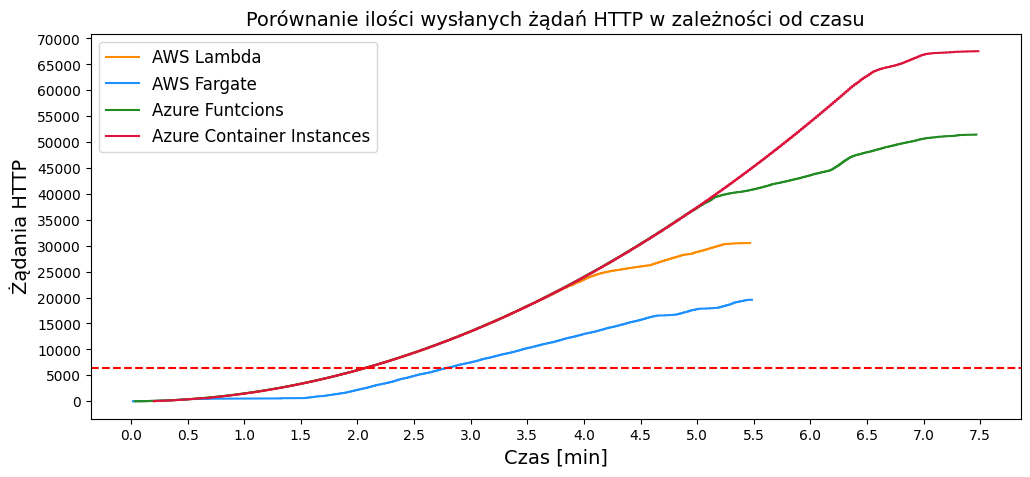

In [ ]:
plt.figure(figsize=(12, 5))
for i in range (0, len(results_paths)):
    plt.plot(x_time_min[i], x_reqs[i], label = labels_service[i], color=colors[i])
plt.locator_params(axis='x', nbins=20)
plt.locator_params(axis='y', nbins=20)
plt.xlabel('Czas [min]', fontsize=14)
plt.ylabel('Żądania HTTP', fontsize=14)
plt.title('Porównanie ilości wysłanych żądań HTTP w zależności od czasu', fontsize=14)
plt.legend(fontsize=12)
plt.axhline(6400, color='red', linestyle='--', label='Ilość żądań w przedziale')
plt.show()

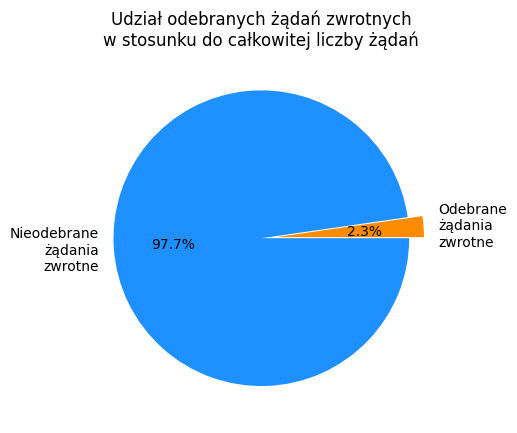

In [ ]:
plot = 0
correct_response = y_correct[plot].count(1)
incorrect_response = y_correct[plot].count(0)

labels = ["Odebrane\nżądania\nzwrotne", "Nieodebrane\nżądania\nzwrotne"]
values = [correct_response/len(y_correct[plot]), incorrect_response/len(y_correct[plot])]

plt.pie(values, labels=labels, colors=[colors[0],colors[1]], autopct='%1.1f%%', explode = [.1,0])
plt.title('Udział odebranych żądań zwrotnych\nw stosunku do całkowitej liczby żądań')
plt.show()

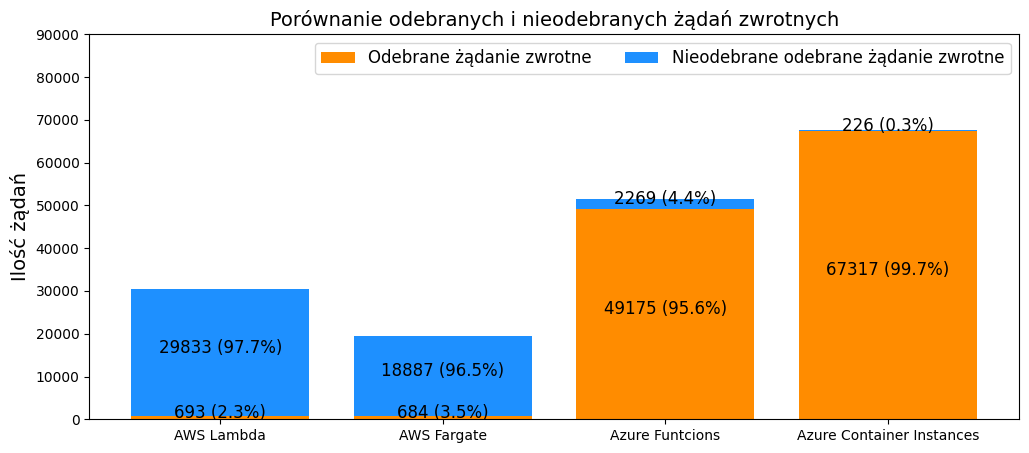

In [ ]:
series_correct = []
series_incorrect = []
for i in range(0, len(results_paths)):
    series_correct.append(y_correct[i].count(1))
    series_incorrect.append(y_correct[i].count(0))

plt.figure(figsize=(12, 5))
plt.bar(labels_service, series_correct, label='Odebrane żądanie zwrotne', color=colors[0])
plt.bar(labels_service, series_incorrect, bottom=series_correct, label='Nieodebrane odebrane żądanie zwrotne', color=colors[1])
for i in range(0, len(results_paths)):
    incorrect_percentage = round(100 * series_incorrect[i] / len(y_correct[i]), 1)
    correct_percentage = round(100 * series_correct[i] / len(y_correct[i]), 1)
    if incorrect_percentage > 0:
        incorrect_label = f'{series_incorrect[i]} ({incorrect_percentage}%)'
        plt.text(i, series_correct[i] + 0.5 * series_incorrect[i], incorrect_label, ha='center', fontsize=12)
    if correct_percentage > 0:
        correct_label = f'{series_correct[i]} ({correct_percentage}%)'
        plt.text(i, 0.5 * series_correct[i], correct_label, ha='center', fontsize=12)
plt.ylabel('Ilość żądań', fontsize=14)
plt.ylim(0, 90000)
plt.title('Porównanie odebranych i nieodebranych żądań zwrotnych', fontsize=14)
plt.legend(fontsize=12, ncol=2)
plt.show()


In [ ]:
def get_k(liczba):
    if liczba < 1000:
        return str(liczba)
    else:
        if liczba % 1000 == 0:
            return f"{liczba//1000}k"
        else:
            return f"{liczba/1000:.1f}k"


In [ ]:
group_size = 125*60
group_numbers = []
groups = []
last_group = []
series_correct = []
series_incorrect = []
labels = []

for i in range (0, len(results_paths)):
    group_numbers.append(math.ceil(len(y_correct[i]) / group_size))
    groups.append([y_correct[i][j * group_size: (j + 1) * group_size] for j in range(group_numbers[i] - 1)])
    last_group.append(y_correct[i][(group_numbers[i] - 1) * group_size:])

    series_correct.append([group.count(1) for group in groups[i]])
    series_correct[i].append(last_group[i].count(1))
    series_incorrect.append([group.count(0) for group in groups[i]])
    series_incorrect[i].append(last_group[i].count(0))
    labels.append([f'{get_k(i*group_size)}-{get_k((i+1)*group_size)}' for i in range(group_numbers[i] - 1)])
    labels[i].append(f'{get_k((group_numbers[i]-1)*group_size)}-{len(y_correct[i])-1}')
    #labels.append([f'{i*group_size}-{(i+1)*group_size}' for i in range(group_numbers[i] - 1)])
    #labels[i].append(f'{(group_numbers[i]-1)*group_size}-{len(y_correct[i])-1}')

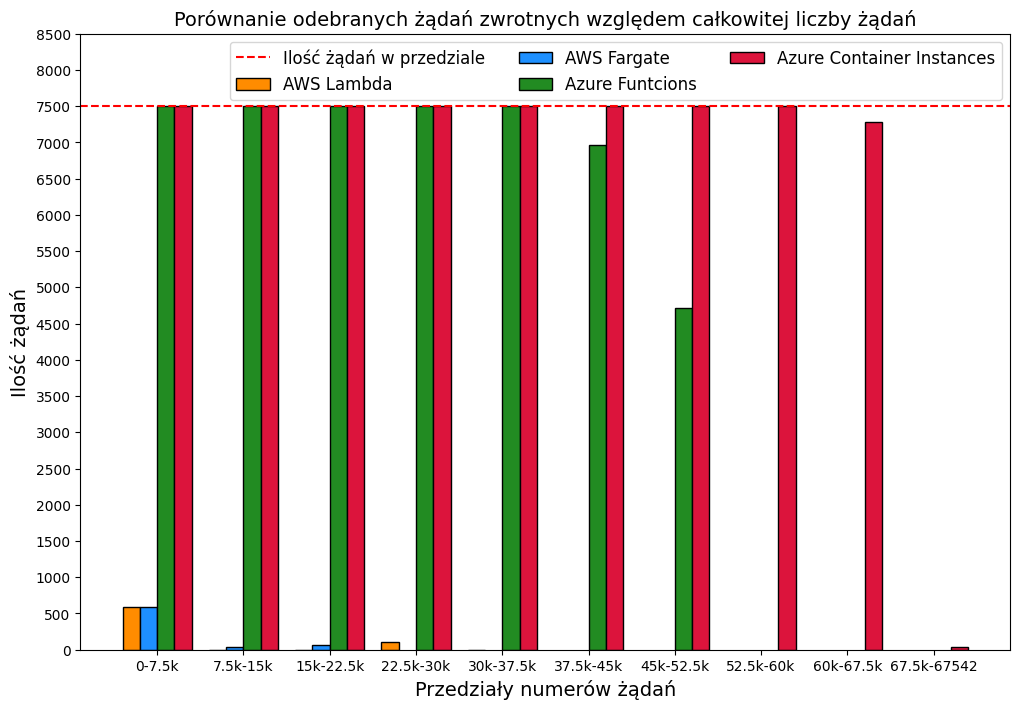

In [ ]:
width = 0.20
shift = [0, 0.5, 1, 1.5, 2]
shift = [0, 0.5, 1, 1.5, 2, 2.5, 3]
plt.figure(figsize=(12, 8))
x = []
for i in range (0, len(results_paths)):
    x.append(np.arange(len(labels[i])))
    plt.bar(x[i]+(i-shift[len(results_paths)-1])*width, series_correct[i], width, label=f'{labels_service[i]}', color=colors[i], edgecolor='black')
    #plt.bar(x[i]+(i-shift[len(results_paths)-1])*width, series_incorrect[i], width, bottom=series_correct[i], label=f'Nieodebrane - {labels_service[i]}', color=colors[i*2+1], edgecolor='black')
plt.axhline(group_size, color='red', linestyle='--', label='Ilość żądań w przedziale')
plt.locator_params(axis='y', nbins=20)
plt.xticks(max(x, key=len), max(labels, key=len))
plt.xlabel('Przedziały numerów żądań', fontsize=14)
plt.ylim(0, 8500)
plt.ylabel('Ilość żądań', fontsize=14)
plt.title('Porównanie odebranych żądań zwrotnych względem całkowitej liczby żądań', fontsize=14)
plt.legend(ncol=3, fontsize=12)
plt.show()

In [ ]:
plot = 1
group_size = int(len(y_correct[plot])/10)
group_numbers = math.ceil(len(y_correct[plot]) / group_size)
groups = [y_correct[plot][i * group_size: (i + 1) * group_size] for i in range(group_numbers - 1)]
last_group = y_correct[plot][(group_numbers - 1) * group_size:]

series_correct = [group.count(1) for group in groups]
#series_correct.append(last_group.count(1))
series_incorrect = [group.count(0) for group in groups]
#series_incorrect.append(last_group.count(0))
labels = [f'{get_k(i*group_size)}-{get_k((i+1)*group_size)}' for i in range(group_numbers - 1)]
#labels.append(f'{get_k((group_numbers-1)*group_size)}-{len(y_correct[plot])-1}')

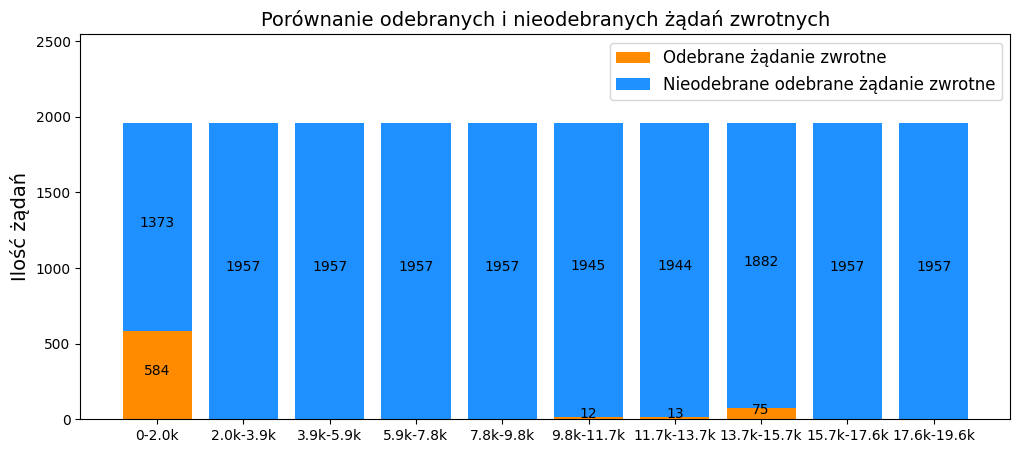

In [ ]:
plt.figure(figsize=(12, 5))
plt.bar(labels, series_correct, label='Odebrane żądanie zwrotne', color=colors[0])
plt.bar(labels, series_incorrect, bottom=series_correct, label='Nieodebrane odebrane żądanie zwrotne', color=colors[1])
for i in range(0, len(series_correct)):
    if series_incorrect[i] > 0:
        plt.text(i, series_correct[i] + 0.5 * series_incorrect[i], f'{series_incorrect[i]}', ha='center')
    if series_correct[i] > 0:
        plt.text(i, 0.5 * series_correct[i], f'{series_correct[i]}', ha='center')
plt.ylim(0, 1.3 * group_size)
plt.ylabel('Ilość żądań', fontsize=14)
plt.title('Porównanie odebranych i nieodebranych żądań zwrotnych', fontsize=14)
plt.legend(fontsize=12)
plt.show()


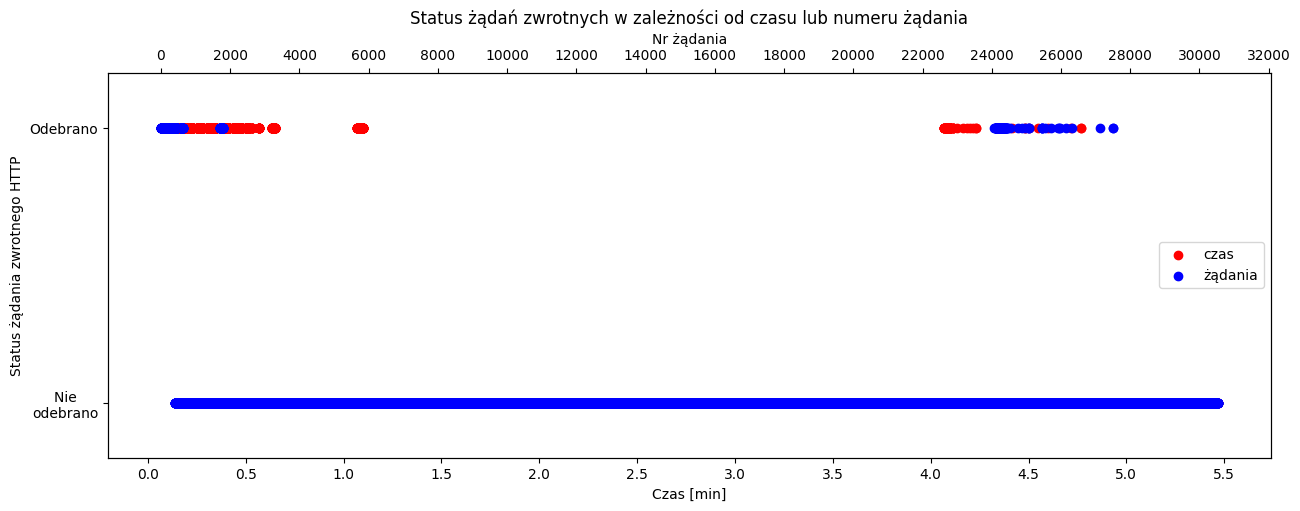

In [ ]:
plot = 0

fig, ax1 = plt.subplots(figsize=(15, 5))
ax1.scatter(x_time_min[plot], y_correct[plot], label='czas', color='red')
ax2 = ax1.twiny()
ax2.scatter(x_reqs[plot], y_correct[plot], label='żądania', color='blue')

ax1.set_ylim(-0.2, 1.2)
ax1.set_yticks([0, 1], ['Nie     \nodebrano', 'Odebrano'])
ax1.locator_params(axis='x', nbins=20)
ax2.locator_params(axis='x', nbins=20)
ax1.set_xlabel('Czas [min]')
ax2.set_xlabel('Nr żądania')
ax1.set_ylabel('Status żądania zwrotnego HTTP')
ax1.set_title('Status żądań zwrotnych w zależności od czasu lub numeru żądania')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='right')

plt.show()

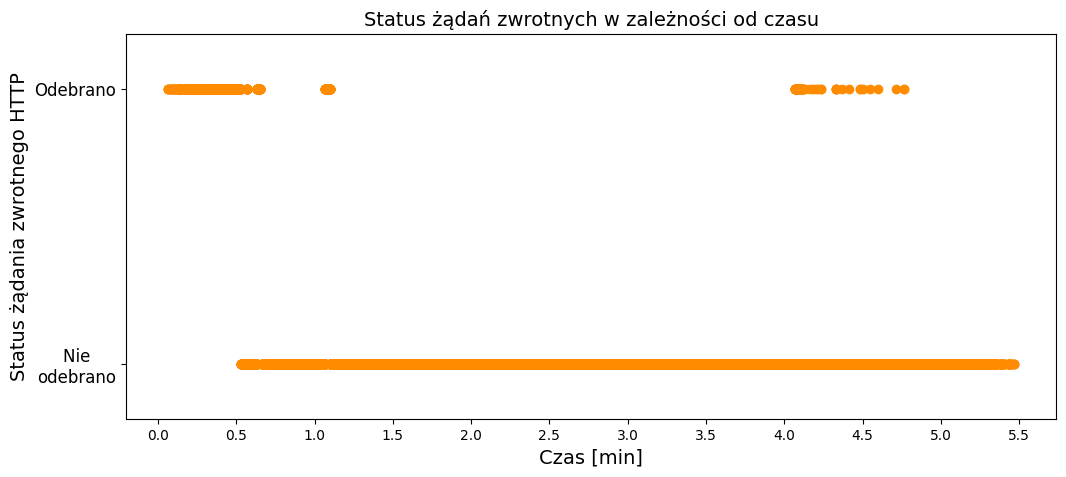

In [ ]:
plot = 0
plt.figure(figsize=(12, 5))
plt.scatter(x_time_min[plot], y_correct[plot], color=colors[0])
plt.ylim(-0.2, 1.2) 
plt.yticks([0, 1], ['Nie     \nodebrano', 'Odebrano'], fontsize=12)
plt.locator_params(axis='x', nbins=20)
plt.xlabel('Czas [min]', fontsize=14)
plt.ylabel('Status żądania zwrotnego HTTP', fontsize=14)
plt.title('Status żądań zwrotnych w zależności od czasu', fontsize=14)
plt.show()

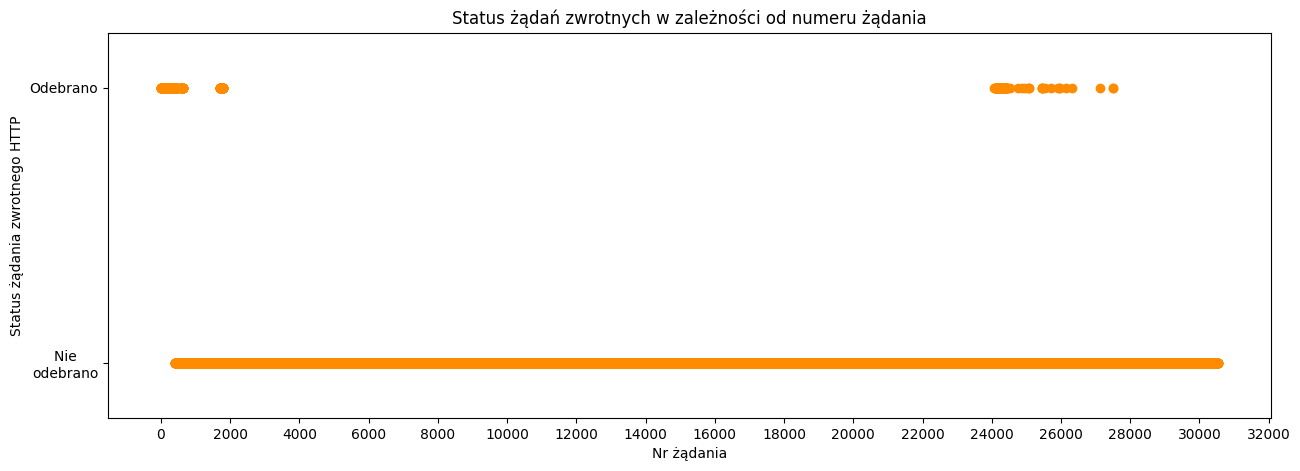

In [ ]:
plot = 0
plt.figure(figsize=(15, 5))
plt.scatter(x_reqs[plot], y_correct[plot], color=colors[0])
plt.ylim(-0.2, 1.2) 
plt.yticks([0, 1], ['Nie     \nodebrano', 'Odebrano'])
plt.locator_params(axis='x', nbins=20)
plt.xlabel('Nr żądania')
plt.ylabel('Status żądania zwrotnego HTTP')
plt.title('Status żądań zwrotnych w zależności od numeru żądania')
plt.show()

### Comparing the ratios of correct response to all requests

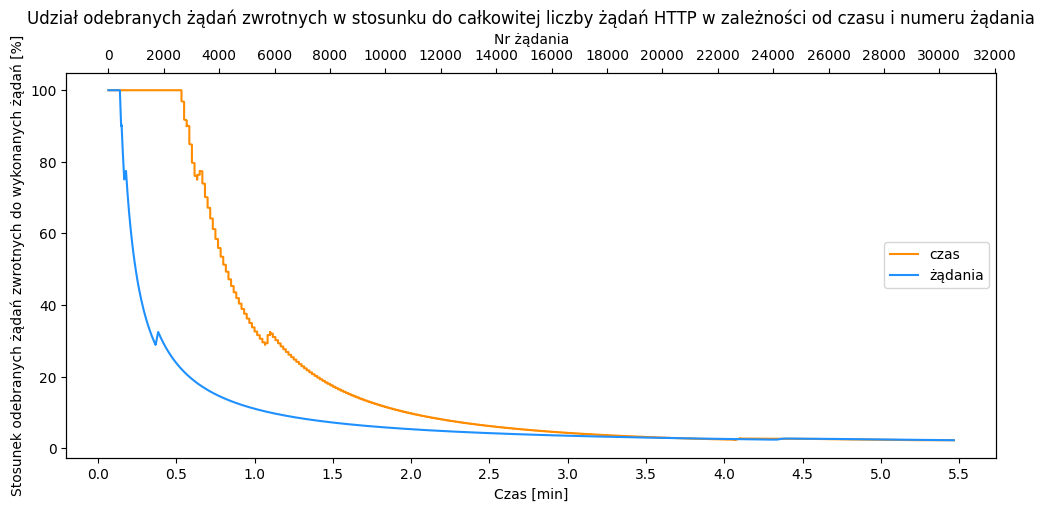

In [ ]:
plot = 0

fig, ax1 = plt.subplots(figsize=(12, 5))
ax1.plot(x_time_min[plot], y_rate[plot], label='czas', color=colors[0])
ax2 = ax1.twiny()
ax2.plot(x_reqs[plot], y_rate[plot], label='żądania', color=colors[1])

ax1.locator_params(axis='x', nbins=20)
ax2.locator_params(axis='x', nbins=20)
ax1.set_xlabel('Czas [min]')
ax2.set_xlabel('Nr żądania')
ax1.set_ylabel('Stosunek odebranych żądań zwrotnych do wykonanych żądań [%]')
ax1.set_title('Udział odebranych żądań zwrotnych w stosunku do całkowitej liczby żądań HTTP w zależności od czasu i numeru żądania')
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='right')

plt.show()

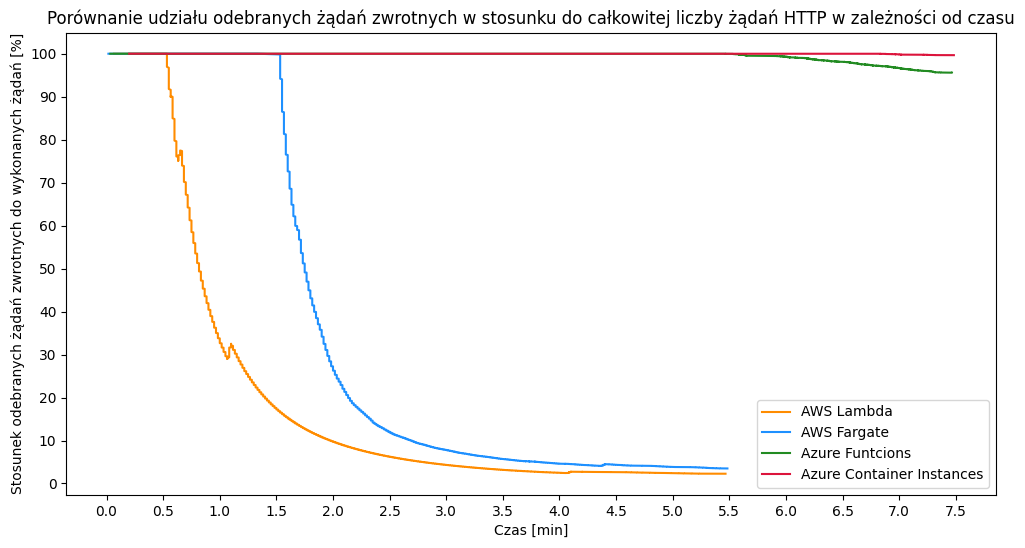

In [ ]:
plt.figure(figsize=(12, 6))
for i in range (0, len(results_paths)):
    plt.plot(x_time_min[i], y_rate[i], label = labels_service[i], color=colors[i])
plt.locator_params(axis='x', nbins=20)
plt.locator_params(axis='y', nbins=20)
plt.xlabel('Czas [min]')
plt.ylabel('Stosunek odebranych żądań zwrotnych do wykonanych żądań [%]')
plt.title('Porównanie udziału odebranych żądań zwrotnych w stosunku do całkowitej liczby żądań HTTP w zależności od czasu')
plt.legend()
#plt.axvline(x=10, color='g', linestyle=':')
plt.show()

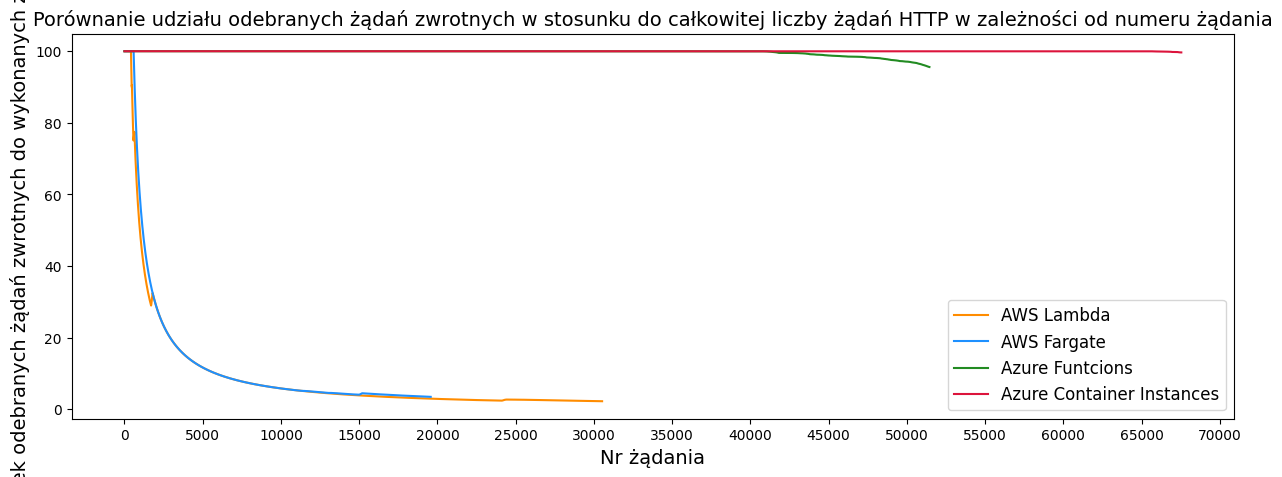

In [ ]:
plt.figure(figsize=(15, 5))
for i in range (0, len(results_paths)):
    plt.plot(x_reqs[i], y_rate[i], label = labels_service[i], color=colors[i])
plt.locator_params(axis='x', nbins=20)
plt.xlabel('Nr żądania', fontsize=14)
plt.ylabel('Stosunek odebranych żądań zwrotnych do wykonanych żądań [%]', fontsize=14)
plt.title('Porównanie udziału odebranych żądań zwrotnych w stosunku do całkowitej liczby żądań HTTP w zależności od numeru żądania', fontsize=14)
plt.legend(fontsize=12)
plt.show()

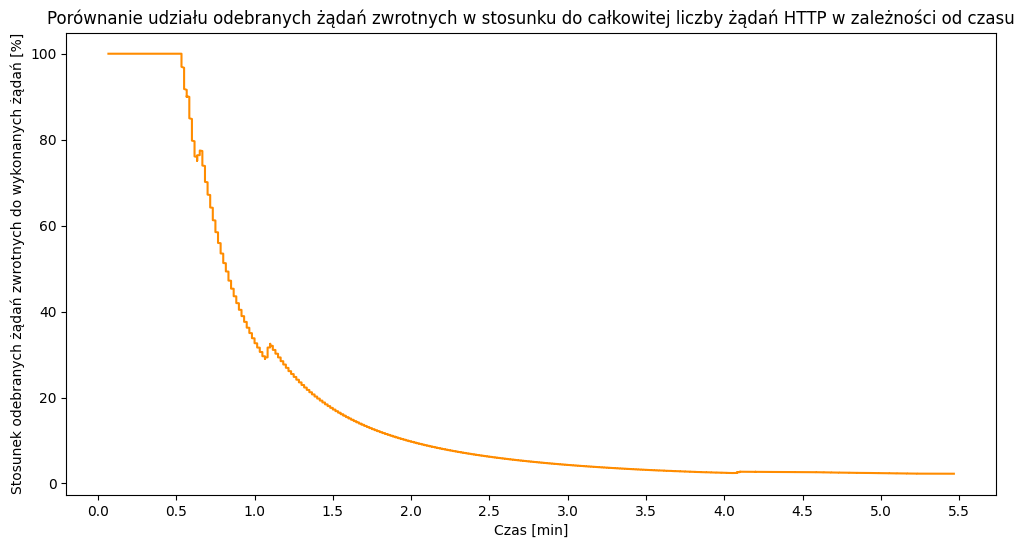

In [ ]:
plot = 0
plt.figure(figsize=(12, 6))
plt.plot(x_time_min[plot], y_rate[plot], color=colors[0])
plt.locator_params(axis='x', nbins=20)
plt.locator_params(axis='y', nbins=10)
plt.xlabel('Czas [min]')
plt.ylabel('Stosunek odebranych żądań zwrotnych do wykonanych żądań [%]')
plt.title('Porównanie udziału odebranych żądań zwrotnych w stosunku do całkowitej liczby żądań HTTP w zależności od czasu')
plt.show()

### Plot of virtual users in time/requests (single plot)

In [ ]:
x_time_vus = []
y_vus = []
for i in range (0, len(results_paths)):
    x_time_vus.append([])
    y_vus.append([])
    for j in range(0, len(results_data[i])):       
        if results_data[i][j]['metric'] == "vus":
            if 'time' in results_data[i][j]['data']:
                time = int(parser.isoparse(results_data[i][j]['data']['time']).timestamp())
                x_time_vus[i].append((time - time_start[i])/time_unit)
                y_vus[i].append(results_data[i][j]['data']['value'])



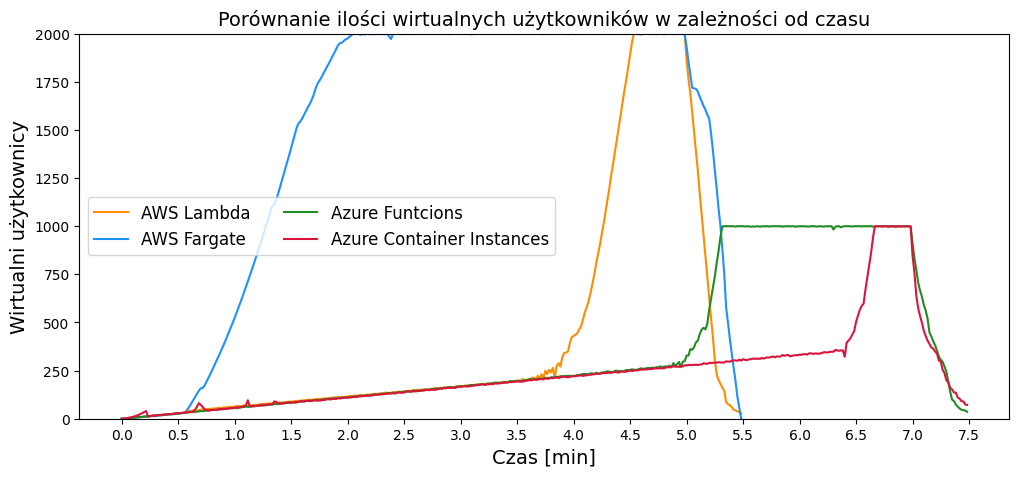

In [ ]:
plt.figure(figsize=(12, 5))
for i in range (0, len(results_paths)):
    plt.plot(x_time_vus[i], y_vus[i], label = labels_service[i], color=colors[i])
plt.locator_params(axis='x', nbins=20)
plt.xlabel('Czas [min]', fontsize=14)
plt.ylabel('Wirtualni użytkownicy', fontsize=14)
plt.title('Porównanie ilości wirtualnych użytkowników w zależności od czasu', fontsize=14)
plt.legend(ncol=2, fontsize=12)
plt.ylim(0, 2000)
plt.show()

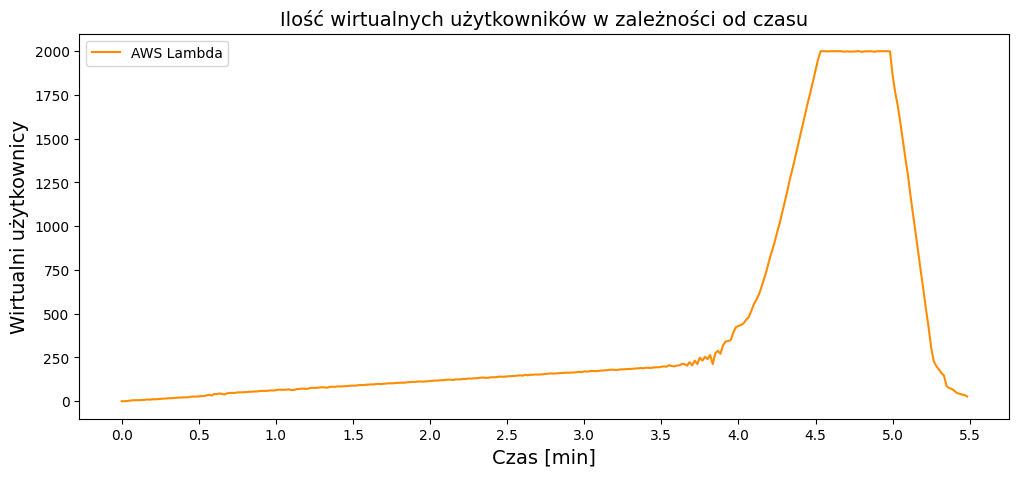

In [ ]:
plot = 0
plt.figure(figsize=(12, 5))
plt.plot(x_time_vus[plot], y_vus[plot], label = labels_service[plot], color=colors[0])
plt.locator_params(axis='x', nbins=20)
plt.xlabel('Czas [min]', fontsize=14)
plt.ylabel('Wirtualni użytkownicy', fontsize=14)
plt.title('Ilość wirtualnych użytkowników w zależności od czasu', fontsize=14)
plt.legend()
plt.show()

### Plot of request response time in time (single plot)

In [ ]:
x_time_duration = []
x_time_correct_duration = []
x_reqs_duration = []
y_duration = []
y_correct_duration = []
for i in range (0, len(results_paths)):
    x_time_duration.append([])
    x_time_correct_duration.append([])
    x_reqs_duration.append([])
    y_correct_duration.append([])
    y_duration.append([])
    for j in range(0, len(results_data[i])):       
        if results_data[i][j]['metric'] == "http_req_duration":
            if 'time' in results_data[i][j]['data']:
                reqs_duration_counter += 1
                time = int(parser.isoparse(results_data[i][j]['data']['time']).timestamp())
                x_time_duration[i].append((time - time_start[i])/time_unit)
                x_reqs_duration[i].append(reqs_duration_counter)
                y_duration[i].append(results_data[i][j]['data']['value'])
                if results_data[i][j]['data']['tags']['expected_response'] == "true":
                    x_time_correct_duration[i].append((time - time_start[i])/time_unit)
                    y_correct_duration[i].append(results_data[i][j]['data']['value'])


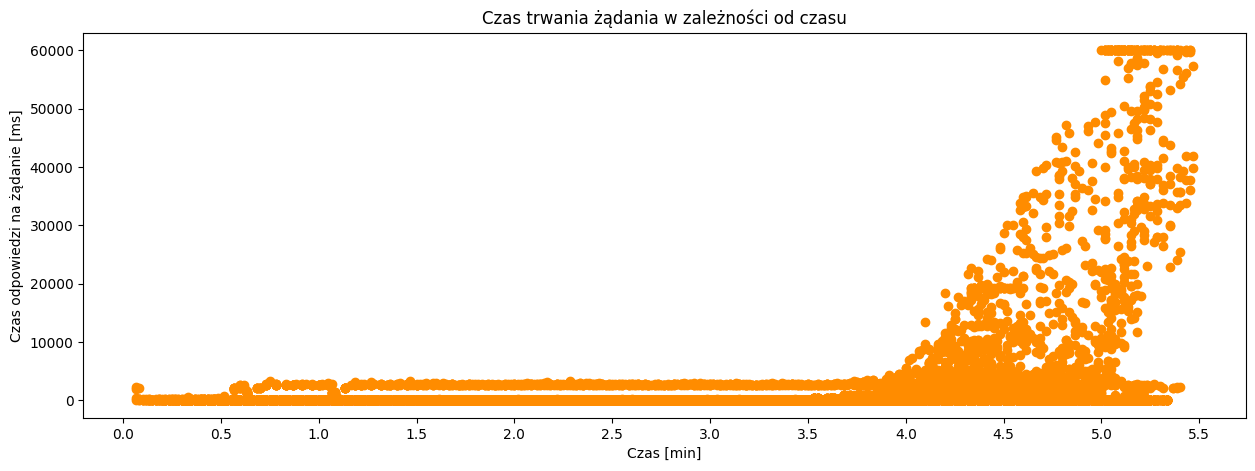

In [ ]:
plot = 0
plt.figure(figsize=(15, 5))
plt.scatter(x_time_duration[plot], y_duration[plot], color=colors[0])
plt.locator_params(axis='x', nbins=20)
plt.xlabel('Czas [min]')
plt.ylabel('Czas odpowiedzi na żądanie [ms]')
plt.title('Czas trwania żądania w zależności od czasu')
plt.show()

### Plot of correct request response time in time (single plot)

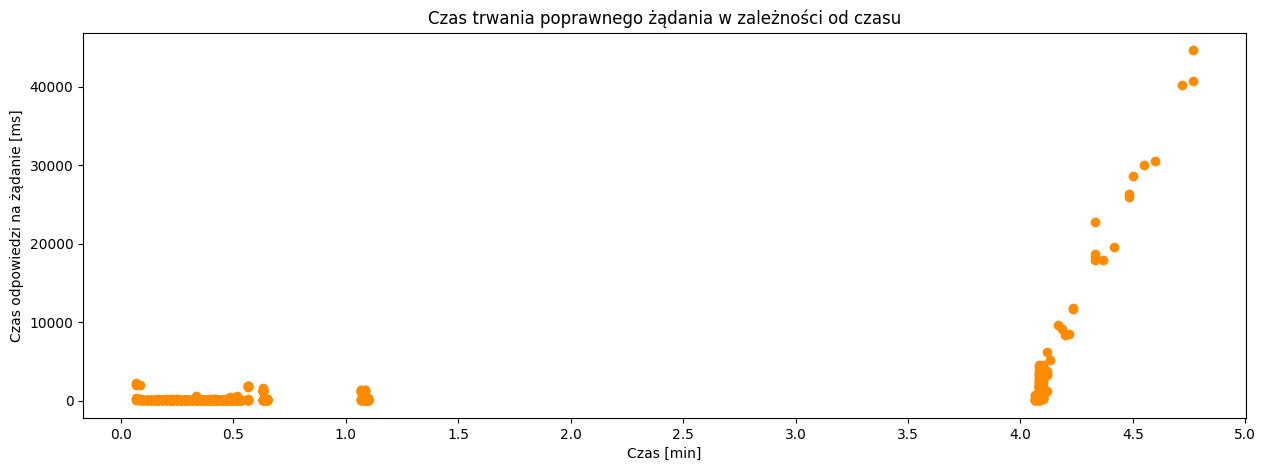

In [ ]:
plot = 0
plt.figure(figsize=(15, 5))
plt.scatter(x_time_correct_duration[plot], y_correct_duration[plot], color=colors[0])
plt.locator_params(axis='x', nbins=20)
plt.xlabel('Czas [min]')
plt.ylabel('Czas odpowiedzi na żądanie [ms]')
plt.title('Czas trwania poprawnego żądania w zależności od czasu')
plt.show()

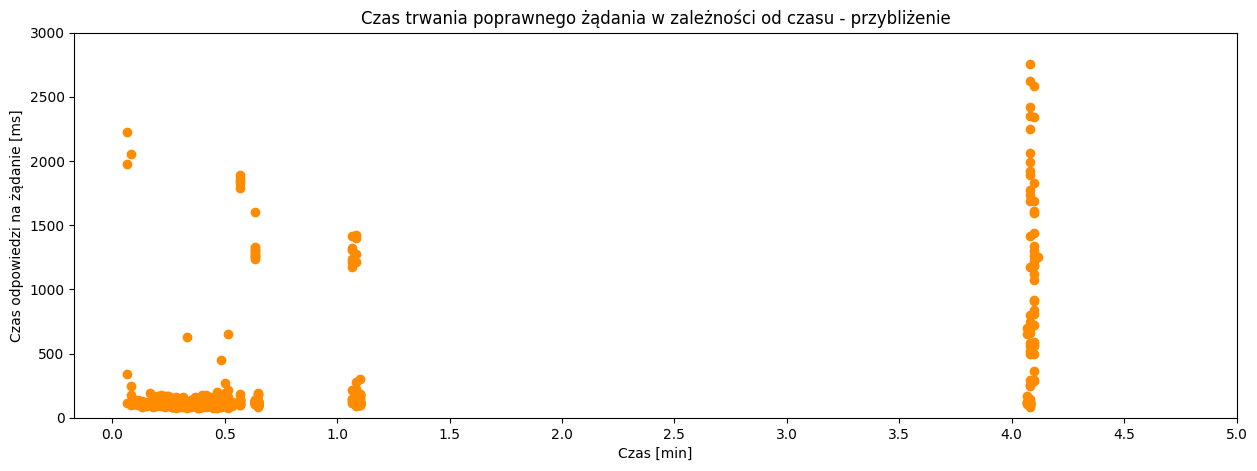

In [ ]:
plot = 0
plt.figure(figsize=(15, 5))
plt.scatter(x_time_correct_duration[plot], y_correct_duration[plot], color=colors[0])
plt.locator_params(axis='x', nbins=20)
plt.xlabel('Czas [min]')
plt.ylabel('Czas odpowiedzi na żądanie [ms]')
plt.ylim(0, 3000) 
plt.title('Czas trwania poprawnego żądania w zależności od czasu - przybliżenie')
plt.show()

In [ ]:
plot = 0
y_correct_duration_mainly = []
limit_value = 300
for i in range (0, len(y_correct_duration[plot])):
    if y_correct_duration[plot][i] < limit_value:
        y_correct_duration_mainly.append(y_correct_duration[plot][i])


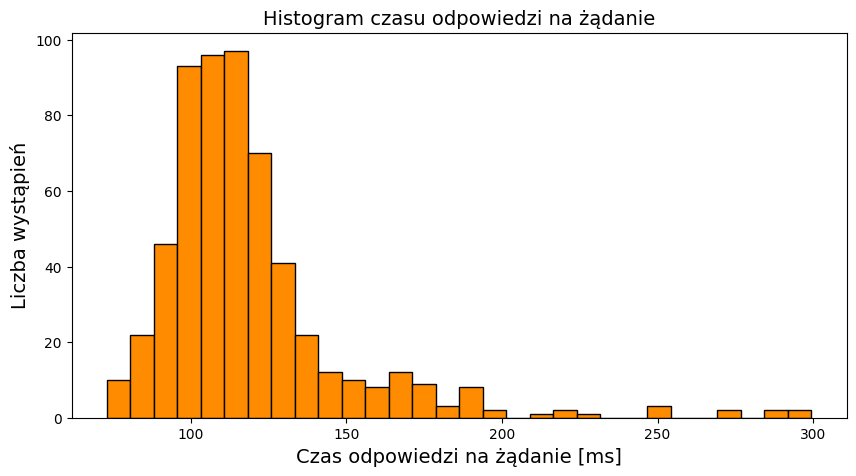

In [ ]:
#plot = 4

plt.figure(figsize=(10, 5))
plt.hist(y_correct_duration_mainly, bins=30, color=colors[0], edgecolor='black')
plt.xlabel('Czas odpowiedzi na żądanie [ms]', fontsize=14)
#plt.xlim(100, 200)
plt.ylabel('Liczba wystąpień', fontsize=14)
plt.title('Histogram czasu odpowiedzi na żądanie', fontsize=14)
plt.show()

In [ ]:
plot = 0
percentile_95 = np.percentile(y_duration[plot], 95)
percentile_90 = np.percentile(y_duration[plot], 90)
percentile_95_2 = np.percentile(y_correct_duration[plot], 95)
percentile_90_2 = np.percentile(y_correct_duration[plot], 90)
percentile_test = np.percentile(y_correct_duration[plot], 84)
print (labels_service[plot])
print("Percentyl 95:", percentile_95)
print("Percentyl 90:", percentile_90)
print("Percentyl 95:", percentile_95_2)
print("Percentyl 90:", percentile_90_2)
print("Percentyl test:", percentile_test)

AWS Lambda
Percentyl 95: 2687.996825
Percentyl 90: 871.87835
Percentyl 95: 3182.676399999997
Percentyl 90: 1329.0912800000006
Percentyl test: 564.8390119999996


## Plots for variable rate

In [ ]:
x_sec = []
x_min = []
y_reqs_sec = []

for i in range (0, len(results_paths)):
    x_sec.append([])
    x_min.append([])
    y_reqs_sec.append([])
    for single_sec in set(x_time_sec[i]):
        reqs_counter = 0
        for sec in x_time_sec[i]:
            if sec == single_sec:
                reqs_counter += 1
        y_reqs_sec[i].append(reqs_counter)
        x_sec[i].append(single_sec)
        x_min[i].append(single_sec/60)
    

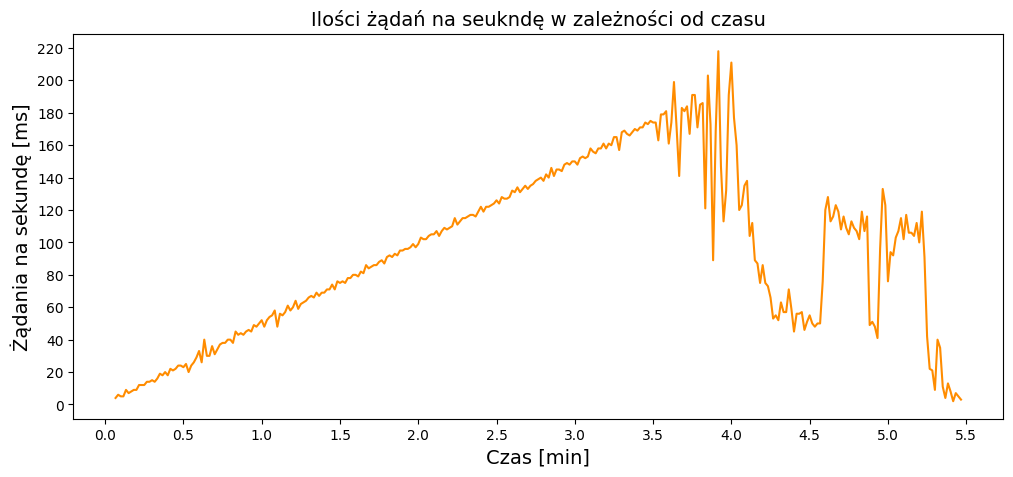

In [ ]:
plot = 0
plt.figure(figsize=(12, 5))
plt.plot(x_min[plot], y_reqs_sec[plot], color=colors[0])
plt.locator_params(axis='x', nbins=20)
plt.locator_params(axis='y', nbins=20)
plt.xlabel('Czas [min]', fontsize=14)
plt.ylabel('Żądania na sekundę [ms]', fontsize=14)
plt.title('Ilości żądań na seukndę w zależności od czasu', fontsize=14)
plt.show()

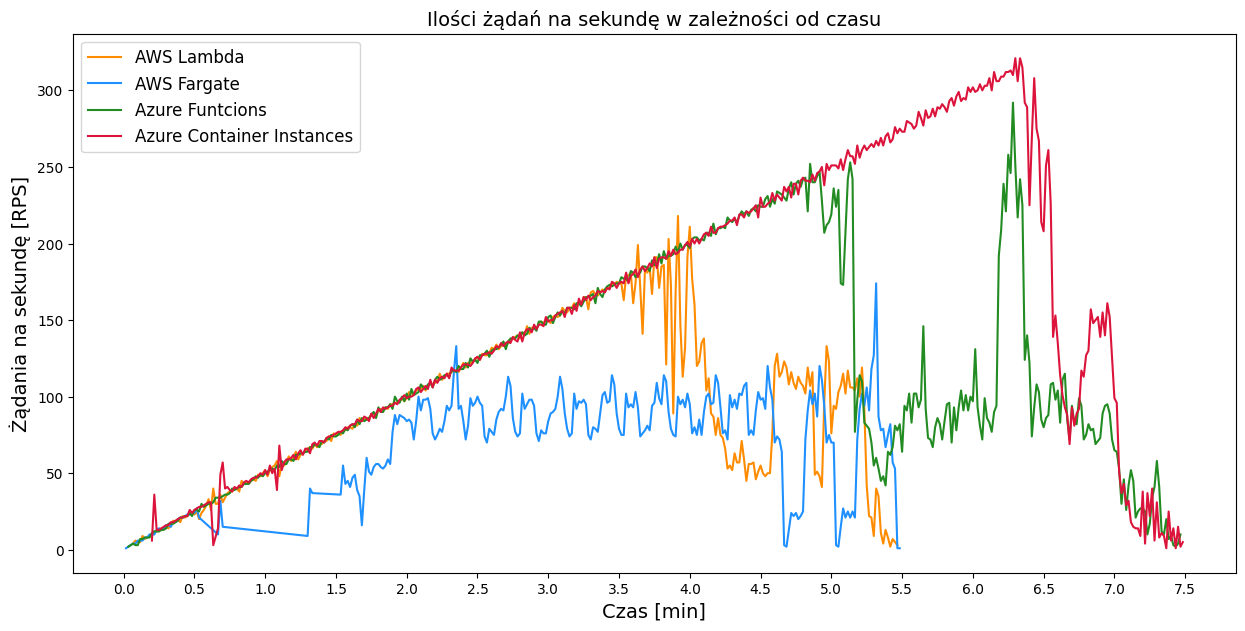

In [ ]:
plt.figure(figsize=(15, 7))
for i in range (0, len(results_paths)):
    plt.plot(x_min[i][::], y_reqs_sec[i][::], label = labels_service[i], color=colors[i])
plt.locator_params(axis='x', nbins=20)
plt.xlabel('Czas [min]', fontsize=14)
plt.ylabel('Żądania na sekundę [RPS]', fontsize=14)
plt.title('Ilości żądań na sekundę w zależności od czasu', fontsize=14)
plt.legend(fontsize=12)
plt.show()

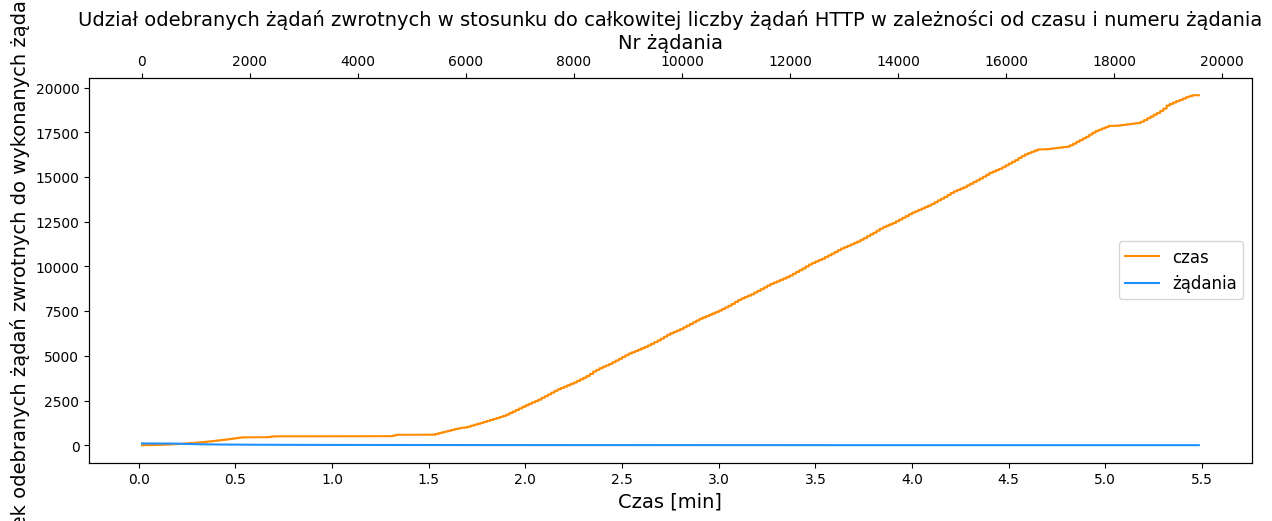

In [ ]:
plot = 1

fig, ax1 = plt.subplots(figsize=(15, 5))
ax1.plot(x_time_min[plot], x_reqs[plot], label='czas', color=colors[0])
ax2 = ax1.twiny()
ax2.plot(x_reqs[plot], y_rate[plot], label='żądania', color=colors[1])

ax1.locator_params(axis='x', nbins=20)
ax2.locator_params(axis='x', nbins=20)
ax1.set_xlabel('Czas [min]', fontsize=14)
ax2.set_xlabel('Nr żądania', fontsize=14)
ax1.set_ylabel('Stosunek odebranych żądań zwrotnych do wykonanych żądań [%]', fontsize=14)
ax1.set_title('Udział odebranych żądań zwrotnych w stosunku do całkowitej liczby żądań HTTP w zależności od czasu i numeru żądania', fontsize=14)
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='right', fontsize=12)

plt.show()